# Global adaptive time-stepping for a locally compressed monolayer due to a single proliferation event

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
separation = 0.3 # initial separation between daughter cells

dim = 2

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [9]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [7]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells, -1))
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i,1]])
    plt.show()

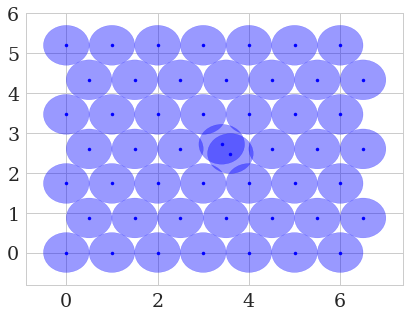

In [10]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

In [8]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


# No Jacobian - accuracy bound only

Initial step cubic 0.022662647104968795
Stability bound estimate cubic 0.12027990666832933
Initial step pw. quad. 0.038079421842220025
Stability bound estimate pw. quad. 0.12688909508485124
Initial step GLS 0.061665340954464055
Stability bound estimate GLS 0.15657023921887214


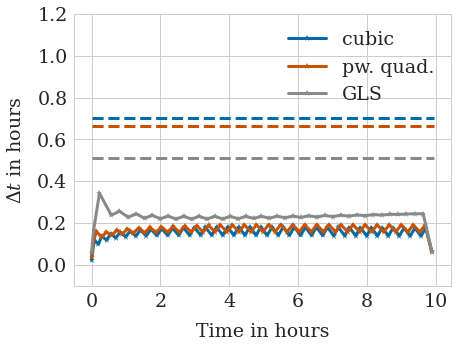

In [9]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.05,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Nothing to delete.
Initial step cubic 0.0032049822895122227
Stability bound estimate cubic 0.09572577542651237
Nothing to delete.
Initial step pw. quad. 0.005385243481659383
Stability bound estimate pw. quad. 0.1299561443246981
Nothing to delete.
Initial step GLS 0.008720796150616413
Stability bound estimate GLS 0.19982936955596697


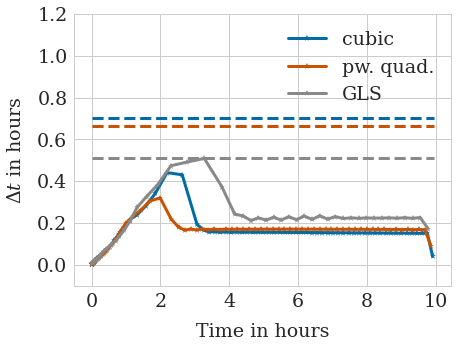

In [10]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [11]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


## Checking that the center of gravity is preserved

In [12]:
coords_t0 = np.array([cell.position for cell in sheet])
cg_t0 = coords_t0.sum(axis=0)/len(sheet)

In [13]:
cg_t0

array([3.22      , 2.59807621])

In [22]:
for force in force_names:
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "eta":0.0001}, seed=seed)
    
    for clt in history:
        coords_t = np.array([cell.position for cell in clt])
        cg_t = coords_t.sum(axis=0)/len(clt)
        assert(np.count_nonzero(np.isclose(np.abs(cg_t - cg_t0), 0, atol=0.00000001))==dim)
    print('Center of gravity preserved over time for '+force+' force.')


Center of gravity preserved over time for cubic force.
Center of gravity preserved over time for pw. quad. force.
Center of gravity preserved over time for GLS force.


# Using the Jacobian to obtain the stability bound

Text(0, 0.5, '$\\Delta t$ in hours')

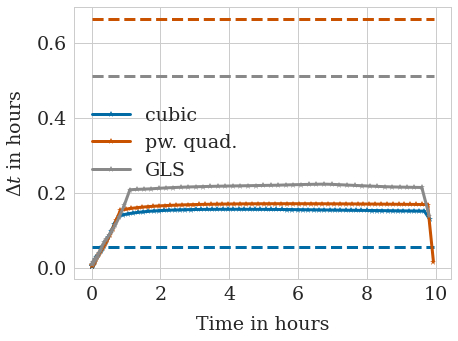

In [12]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')


## Checking that the center of gravity is preserved

In [23]:
coords_t0 = np.array([cell.position for cell in sheet])
cg_t0 = coords_t0.sum(axis=0)/len(sheet)

In [24]:
cg_t0

array([3.22      , 2.59807621])

In [25]:
for force in force_names:
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    
    for clt in history:
        coords_t = np.array([cell.position for cell in clt])
        cg_t = coords_t.sum(axis=0)/len(clt)
        assert(np.count_nonzero(np.isclose(np.abs(cg_t - cg_t0), 0, atol=0.00000001))==dim)
    print('Center of gravity preserved over time for '+force+' force.')


Center of gravity preserved over time for cubic force.
Center of gravity preserved over time for pw. quad. force.
Center of gravity preserved over time for GLS force.


## Looking at eigenvalues and eigenvectors

In [62]:
## Cubic force

In [23]:
force = 'cubic'

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,50*dim, 50*dim), order='F')



### Count number of negative, zero and positive eigenvalues

In [14]:
eigenvalues_cubic.shape

(86, 100)

In [15]:
np.count_nonzero(np.isclose(eigenvalues_cubic, 0, atol=0.00001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
np.count_nonzero(eigenvalues_cubic > 0.00001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
eigenvalues_cubic[-1,:]

array([-1.32386828e+01, -9.81233647e+00, -9.70214597e+00, -9.54984411e+00,
       -7.71355434e+00, -7.52337854e+00, -7.45979635e+00, -7.34621344e+00,
       -7.05482873e+00, -6.93081916e+00, -6.85267090e+00, -6.74247553e+00,
       -6.64454229e+00, -6.59438016e+00, -6.52875585e+00, -6.46762239e+00,
       -6.43611077e+00, -6.23920213e+00, -6.01279577e+00, -5.90551015e+00,
       -5.83091494e+00, -5.79339713e+00, -5.68176760e+00, -5.63099697e+00,
       -5.47198998e+00, -5.26150247e+00, -5.08983438e+00, -4.95807334e+00,
       -4.89218782e+00, -4.86641272e+00, -4.78440746e+00, -4.66411530e+00,
       -4.56659768e+00, -4.33253584e+00, -4.24345219e+00, -4.10192052e+00,
       -3.99955741e+00, -3.97007756e+00, -3.80138204e+00, -3.69948138e+00,
       -3.55729801e+00, -3.49251876e+00, -3.33126417e+00, -3.22870234e+00,
       -3.18459674e+00, -3.14822943e+00, -3.01888745e+00, -2.99911182e+00,
       -2.78501136e+00, -2.75940694e+00, -2.73060265e+00, -2.69298345e+00,
       -2.61765050e+00, -

In [20]:
eigenvectors_cubic.shape

(86, 100, 100)

In [21]:
eigenvectors_cubic[-1, :, -4]

array([ 0.11667199,  0.11897585,  0.11543945,  0.09515667,  0.08455686,
        0.02029086,  0.07291634, -0.07859278,  0.08830608, -0.1342002 ,
        0.08992209, -0.1054512 ,  0.0970232 , -0.07691785,  0.16033752,
        0.09010646,  0.15746499,  0.09287969,  0.12396059, -0.01905523,
        0.10922019, -0.12737561,  0.06668756, -0.10974408,  0.06724724,
       -0.09613595,  0.06479549, -0.051502  ,  0.14226381,  0.04818979,
        0.16175684,  0.08352757,  0.206622  ,  0.11207119,  0.19793459,
       -0.0891417 ,  0.018602  , -0.06589625,  0.026758  , -0.12232729,
        0.02020688, -0.06738073,  0.05876157,  0.06068189,  0.04832399,
        0.10554889,  0.02534648,  0.20074461, -0.03453446, -0.02444627,
       -0.07274131, -0.17310405, -0.08076908, -0.10154531, -0.07570574,
       -0.01832428, -0.02225899,  0.03162828, -0.02812753,  0.08967058,
       -0.05145105,  0.14034619, -0.04714665,  0.03947598, -0.192765  ,
        0.02131193, -0.19977372, -0.11045   , -0.18249029, -0.08

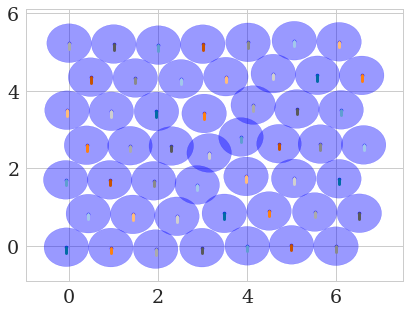

In [24]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -3]) # zero eigenvalue = translation in y

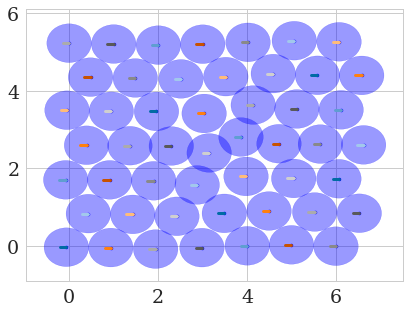

In [25]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -2]) # second zero eigenvalue = translation in x

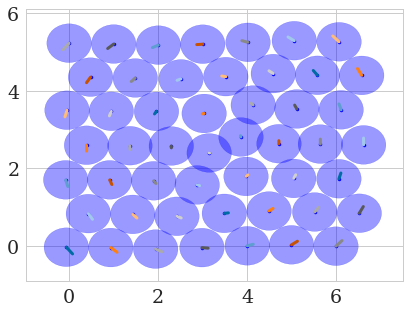

In [26]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -1]) # positive eigenvalue = rotation

In [ ]:
## PWQ force

In [63]:
force = 'pw. quad.'

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending[force]+'.txt')
eigenvectors_pwq = np.loadtxt('eigenvectors'+filename_ending[force]+'.txt')
eigenvectors_pwq = eigenvectors_pwq.reshape((-1,50*dim, 50*dim), order='F')


In [64]:
np.count_nonzero(np.isclose(eigenvalues_pwq, 0, atol=0.00001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
np.count_nonzero(eigenvalues_pwq > 0.00001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [66]:
eigenvalues_pwq[-1,:]

array([-1.18624432e+01, -9.69769639e+00, -9.48703430e+00, -9.22590723e+00,
       -7.89924523e+00, -7.81733293e+00, -7.77480730e+00, -7.60115609e+00,
       -7.31779614e+00, -7.25566201e+00, -7.09860587e+00, -6.98289231e+00,
       -6.96850952e+00, -6.90131305e+00, -6.82267299e+00, -6.71900718e+00,
       -6.60663027e+00, -6.56926010e+00, -6.27972628e+00, -6.20781202e+00,
       -6.09558718e+00, -6.03065617e+00, -5.90499445e+00, -5.80827691e+00,
       -5.62442835e+00, -5.50607388e+00, -5.32728944e+00, -5.17308912e+00,
       -5.10723118e+00, -5.06888092e+00, -4.96450110e+00, -4.85370877e+00,
       -4.76075690e+00, -4.51741552e+00, -4.43893035e+00, -4.26869888e+00,
       -4.14645452e+00, -4.09172513e+00, -3.92526267e+00, -3.84149066e+00,
       -3.70334879e+00, -3.57778666e+00, -3.46195189e+00, -3.37195357e+00,
       -3.32018990e+00, -3.24091702e+00, -3.14796633e+00, -3.10943835e+00,
       -2.91487552e+00, -2.88567224e+00, -2.84799079e+00, -2.82337099e+00,
       -2.69875757e+00, -

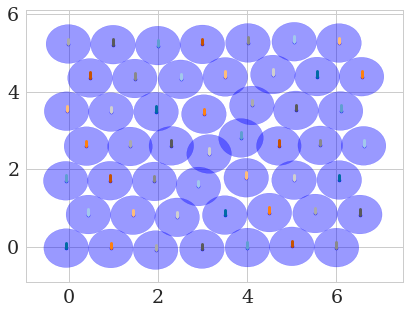

In [67]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_pwq[time_index, :, -4]) # zero eigenvalue = translation in y

In [ ]:
## GLS force

In [48]:
force = 'GLS'

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')
eigenvectors_gls = np.loadtxt('eigenvectors'+filename_ending['GLS']+'.txt')
eigenvectors_gls = eigenvectors_gls.reshape((-1,50*dim, 50*dim), order='F')


In [49]:
np.count_nonzero(np.isclose(eigenvalues_gls, 0, atol=0.00001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [59]:
np.count_nonzero(eigenvalues_gls > 0.00001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5])

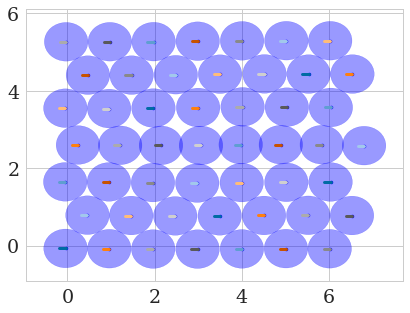

In [61]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_gls[time_index, :, -6]) # zero eigenvalue = translation in y

In [58]:
eigenvalues_gls[time_index, :]

array([-9.34365733e+00, -9.06055562e+00, -8.93855738e+00, -8.91258460e+00,
       -8.84402725e+00, -8.72811621e+00, -8.70493617e+00, -8.60736368e+00,
       -8.45610140e+00, -8.35585197e+00, -8.32045486e+00, -8.19602121e+00,
       -8.15017293e+00, -8.03882497e+00, -7.99588783e+00, -7.91620970e+00,
       -7.73795651e+00, -7.30707166e+00, -7.19294066e+00, -6.79380926e+00,
       -6.74529952e+00, -6.48043070e+00, -6.31638391e+00, -6.26656489e+00,
       -6.06753223e+00, -6.00260023e+00, -5.87732629e+00, -5.81516563e+00,
       -5.71763932e+00, -5.67316937e+00, -5.57402616e+00, -5.40425674e+00,
       -5.33127849e+00, -5.11681193e+00, -4.92429404e+00, -4.89030021e+00,
       -4.60613520e+00, -4.44372639e+00, -4.27306207e+00, -4.19319933e+00,
       -4.05944422e+00, -4.01402495e+00, -3.89715788e+00, -3.88713434e+00,
       -3.79367559e+00, -3.69587089e+00, -3.66421454e+00, -3.50678253e+00,
       -3.25170749e+00, -3.20985483e+00, -3.15081378e+00, -3.11952694e+00,
       -3.00108239e+00, -

# Dependence of initial step and stability bound on number of neigbors

In [29]:
dim = 2
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}

In [30]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
stability_bounds = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sl = [2, 3, 4, 5, 8, 10, 15]
for l in sl:
    sheet = make_hexagonal_mesh(l)
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        sbe = (dts[-2]+dts[-1])/2.0
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])
        stability_bounds[force].append(sbe)
        


Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


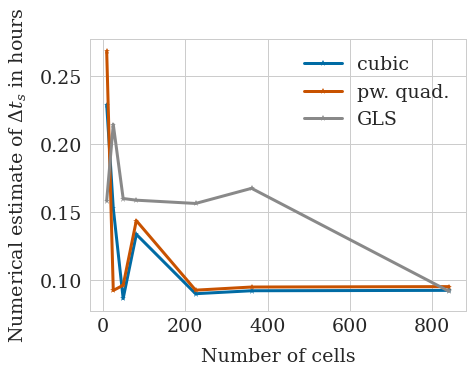

In [31]:
n_cells = [(2*l-1)*(l+(l-1)//2+l//2) for l in sl]
for force in force_names:
    plt.plot(n_cells, stability_bounds[force], '-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_s$ in hours')
plt.savefig('dependence_stability_n_cells.pdf', bbox_inches='tight')

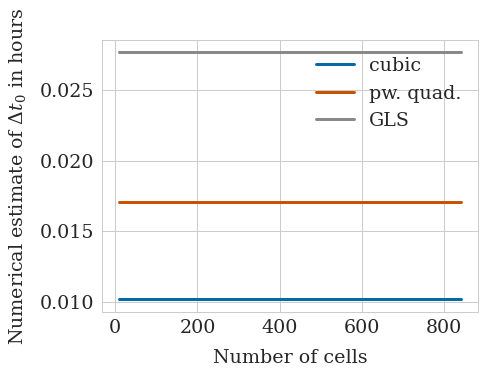

In [32]:
for force in force_names:
    plt.plot(n_cells, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')
plt.savefig('dependence_initial_step_n_cells.pdf', bbox_inches='tight')

# Dependence of the initial step on epsilon

In [33]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sheet = make_hexagonal_mesh(4)

tolerances= [0.01, 0.001, 0.0001]
for eps in tolerances:
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])

        

Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


Text(0, 0.5, 'Numerical estimate of $\\Delta t_0$ in hours')

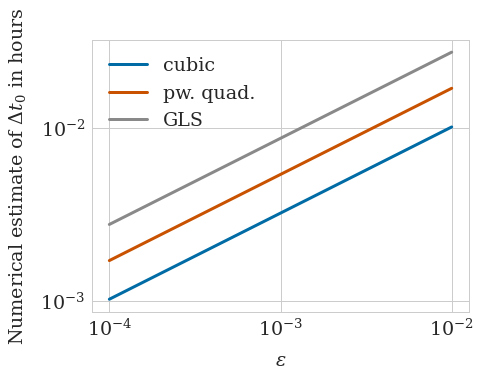

In [34]:
for force in force_names:
    plt.loglog(tolerances, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')

# Plotting $\eta_k$ for a larger sheet

Nothing to delete.
Nothing to delete.
Nothing to delete.


Text(0, 0.5, '$\\Delta t$ in hours')

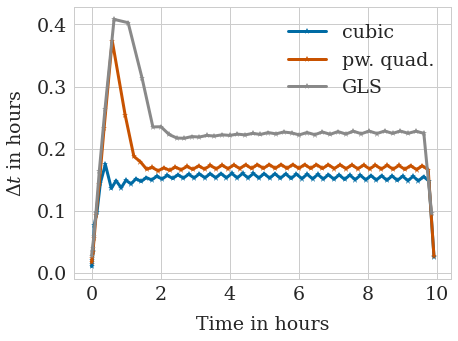

In [35]:
sheet = make_hexagonal_mesh(4)

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')   
    try:
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file' : True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
#    print('Initial step '+force + ' ' +str(dts[0]))
#    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
#    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.savefig('adaptivity_38cells.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_38cells.png', bbox_inches='tight')

In [36]:
AFs = np.loadtxt('AFs'+filename_ending['pw. quad.']+'.txt')
sorted_AFs = np.sort(AFs)


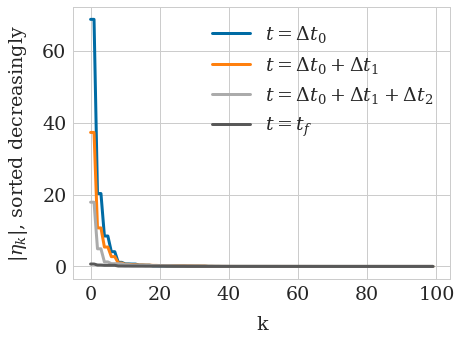

In [37]:
plt.plot(sorted_AFs[0,::-1], label='$t=\Delta t_0$')
plt.plot(sorted_AFs[1,::-1], label='$t=\Delta t_0+\Delta t_1$')
plt.plot(sorted_AFs[2,::-1], label='$t=\Delta t_0+\Delta t_1+\Delta t_2$')

plt.plot(sorted_AFs[-1,::-1], label='$t=t_f$')
plt.xlabel('k')
plt.ylabel('$|\eta_k|$, sorted decreasingly')
plt.legend()
plt.savefig('eta_k_pwq.pdf', bbox_inches='tight')